### week 7


In [230]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [231]:
! source activate example-environment

In [232]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats 

In [233]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()

import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Hot, viridis
from datashader.utils import export_image
from datashader.bokeh_ext import InteractiveImage

from functools import partial

import param
import paramnb
%matplotlib inline
import matplotlib.pyplot as plt

Loading BokehJS ...

In [234]:
%%time
df_main = pd.read_csv('yellow_tripdata_2016-06_ed.xz', parse_dates=['tpep_pickup_datetime'])
df_main.set_index('tpep_pickup_datetime', inplace=True)

CPU times: user 24.7 s, sys: 838 ms, total: 25.5 s
Wall time: 26.4 s


In [250]:
df_loc = pd.read_csv('time_region_102_pickup_count.xz')

df_loc = df_loc.set_index('datetime')
df_loc = df_loc['2016-05-31 23:00:00':]
regions_list = df_loc.columns.astype(int)

<class 'str'>


In [236]:
# загружаем предсказания количества поездок в июне 2016
predictions = pd.read_csv('predictions_2016-06.xz', index_col=0)

loc = predictions['id'].str.split('_')

regions = []; dates = []; hours = []; forwards = []
for x in loc:
    regions.append(x[0])
    dates.append(x[1])
    hours.append(x[2])
    forwards.append(int(x[3]))

df = pd.DataFrame()
df['regions'] = regions
df['datetime']=  [date+' '+hour for date, hour in zip(dates, hours)]
df['predicts'] = forwards
df['datetime'] = [pd.datetime.strptime(row, '%Y-%m-%d %H') for row in df['datetime']]
df['y'] = predictions['y']
df.set_index('datetime', inplace=True)
df_june_predictions = df

In [241]:
class GetData(param.Parameterized):
    hour = param.Integer(default=3, bounds=(0,23))
    date = param.ObjectSelector(default='2016-06-01', 
       objects=np.unique([x.strftime('%Y-%m-%d') for x in  df_loc.index.astype('<M8[D]')]),
                check_on_set=True)

In [285]:
def prep_pred():
    df_pred = df_june_predictions[df_june_predictions.predicts == 1][['regions', 'y']]
    df_pred.columns = ['regions', 'pickups']
    return df_pred

In [289]:
def prep_real():
    t = list()
    ind_list  = list()
    i = 0 
    index = df_loc.index.values
    columns = df_loc.columns
    j = -1
    for row in df_loc.values:
        for i in range(len(columns)):
            t.append([columns[i], row[i]])
            if j < 0:
                k = 0
            else:
                k = j
            ind_list.append(index[k])
        j = j + 1
    df_real = pd.DataFrame(t, index=ind_list, columns = ['regions', 'pickups'])
    return df_real

In [287]:
regions = pd.read_csv('regions.csv', sep=';')

In [320]:
def region_to_coordinates(row):
    region = int(row[0])
    pickups = row[1]
    coordinates = regions[regions.region == region].values[0]
    return np.mean([coordinates[3], coordinates[4]]), np.mean([coordinates[1], coordinates[2]]), pickups

In [321]:
%%time
df_pred = prep_pred().apply(region_to_coordinates,  axis = 1)
df_real = prep_real().apply(region_to_coordinates,  axis = 1)

CPU times: user 1min 57s, sys: 1.1 s, total: 1min 58s
Wall time: 2min 2s


In [380]:
def prepare_data_for_map():
    date = str(GetData.date)
    hour = str(GetData.hour)
    if len(hour) == 1:
        hour = '0%s' % hour
    date_str = '%s %s:00:00' %(date, hour)
    
    pred_arr = df_pred[df_pred.index == date_str].values
    real_arr = df_real[df_real.index == date_str].values
    
    return pred_arr, real_arr

In [381]:
import folium
from folium.plugins import HeatMap
from folium import plugins

In [382]:
def visualize_map(arr):
    new_york_coordinates = (40.72, -73.90)
    map_ny = folium.Map(width=700,height=500, location=new_york_coordinates, zoom_start=11, detect_retina=True)

    szt = plugins.ScrollZoomToggler() # Turn off mouse scrolling
    map_ny.add_child(szt)
    map_ny._repr_html_()
    map_ny

    HeatMap(arr, radius=12).add_to(map_ny)        
    return map_ny

#### 1) карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени 

In [325]:
# выберите дату, час и нажмите кнопку
paramnb.Widgets(GetData, button=True, next_n=3)

<IPython.core.display.Javascript object>

VBox(children=(HTML(value='\n        <style>\n          .ttip { position: relative; display: inline-block; }\n          .ttip .ttiptext { visibility: hidden; background-color: #F8F8F8; outline: #CCCCCC solid thin;\n             color: black; border-radius: 2px; padding: 2px; text-align: center;\n             position: absolute; left: 53%; top: 30px; box-shadow: 7px 7px 10px #DDDDDD;\n             z-index: 100; min-width: 100px; font-size: 80%}\n          .ttip:hover .ttiptext { visibility: visible; }\n          .widget-dropdown .dropdown-menu { width: 100% }\n          .widget-select-multiple select { min-height: 100px; min-width: 300px;}\n        </style>\n        <div class="ttip"><b>GetData</b></div>'), HBox(children=(HTML(value='<div class="ttip" style="padding: 5px; width: 60px;\n                      text-align: right;">date</div>'), Dropdown(options=OrderedDict([('2016-06-01', '2016-06-01'), ('2016-06-02', '2016-06-02'), ('2016-06-03', '2016-06-03'), ('2016-06-04', '2016-06-04'), ('2016-06-05', '2016-06-05'), ('2016-06-06', '2016-06-06'), ('2016-06-07', '2016-06-07'), ('2016-06-08', '2016-06-08'), ('2016-06-09', '2016-06-09'), ('2016-06-10', '2016-06-10'), ('2016-06-11', '2016-06-11'), ('2016-06-12', '2016-06-12'), ('2016-06-13', '2016-06-13'), ('2016-06-14', '2016-06-14'), ('2016-06-15', '2016-06-15'), ('2016-06-16', '2016-06-16'), ('2016-06-17', '2016-06-17'), ('2016-06-18', '2016-06-18'), ('2016-06-19', '2016-06-19'), ('2016-06-20', '2016-06-20'), ('2016-06-21', '2016-06-21'), ('2016-06-22', '2016-06-22'), ('2016-06-23', '2016-06-23'), ('2016-06-24', '2016-06-24'), ('2016-06-25', '2016-06-25'), ('2016-06-26', '2016-06-26'), ('2016-06-27', '2016-06-27'), ('2016-06-28', '2016-06-28'), ('2016-06-29', '2016-06-29'), ('2016-06-30', '2016-06-30')]), value='2016-06-01'))), HBox(children=(HTML(value='<div class="ttip" style="padding: 5px; width: 60px;\n                      text-align: right;">hour</div>'), IntSlider(value=3, continuous_update=False, max=23))), Button(description='Run 3', style=ButtonStyle())), layout=Layout(display='flex', flex_flow='column'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [386]:
arr_real, arr_pred = prepare_data_for_map()
real_map = visualize_map(arr_real)
pred_map = visualize_map(arr_pred)

In [387]:
print ('Предсказанный спрос')
real_map

Предсказанный спрос


In [388]:
print ('Реальный спрос')
pred_map

Реальный спрос


#### 2) временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

In [93]:
class GetCell(param.Parameterized):
    cell = param.ObjectSelector(default=regions_list[0], objects=regions_list, check_on_set=True)

In [21]:
from sklearn.metrics import mean_absolute_error

In [192]:
def prepare_data():
    region = GetCell.cell
    # получаем предсказанное количество поездок в выбранный день и час (из ранее полученной модели) 
    df = df_june_predictions.copy()
    df = df[df['regions'] == str(region)]
    df1 = df[df['predicts'] == int(1)].copy()
    df2 = df[df['predicts'] == int(6)].copy()
    df = pd.concat([df1, df2[-5:]], axis=0)
    prediction_nums = df
    hours = pd.date_range('2016-06-01 00:00:00', periods=720, freq='H')
    prediction_nums.index = hours
    pred_arr = prediction_nums['y'].values
    real_arr = df_loc.loc[:,str(region)].values
    
    return pred_arr, real_arr

In [193]:
def plot_real_pred(real, pred):
    plt.figure(figsize=(18,6))
    plt.plot(real, 'r', label='predicted')
    plt.plot(pred, 'b', label='real values')
    plt.title('2016 June, cell: {}, MAE: {}, XGBRegressor'.format(region, mean_absolute_error(real_arr, pred_arr)))
    plt.ylabel('pickups')
    plt.xlabel('hours in june 2016')
    plt.legend()
    plt.show()

In [191]:
# выберите интересующую ячейку (регион) и намите на кнопку
paramnb.Widgets(GetCell, button=True, next_n=1)

<IPython.core.display.Javascript object>

VBox(children=(HTML(value='\n        <style>\n          .ttip { position: relative; display: inline-block; }\n          .ttip .ttiptext { visibility: hidden; background-color: #F8F8F8; outline: #CCCCCC solid thin;\n             color: black; border-radius: 2px; padding: 2px; text-align: center;\n             position: absolute; left: 53%; top: 30px; box-shadow: 7px 7px 10px #DDDDDD;\n             z-index: 100; min-width: 100px; font-size: 80%}\n          .ttip:hover .ttiptext { visibility: visible; }\n          .widget-dropdown .dropdown-menu { width: 100% }\n          .widget-select-multiple select { min-height: 100px; min-width: 300px;}\n        </style>\n        <div class="ttip"><b>GetCell</b></div>'), HBox(children=(HTML(value='<div class="ttip" style="padding: 5px; width: 60px;\n                      text-align: right;">cell</div>'), Dropdown(options=OrderedDict([('1075', 1075), ('1076', 1076), ('1077', 1077), ('1125', 1125), ('1126', 1126), ('1127', 1127), ('1128', 1128), ('1129', 1129), ('1130', 1130), ('1131', 1131), ('1132', 1132), ('1172', 1172), ('1173', 1173), ('1174', 1174), ('1175', 1175), ('1176', 1176), ('1177', 1177), ('1178', 1178), ('1179', 1179), ('1180', 1180), ('1181', 1181), ('1182', 1182), ('1183', 1183), ('1184', 1184), ('1221', 1221), ('1222', 1222), ('1223', 1223), ('1224', 1224), ('1225', 1225), ('1227', 1227), ('1228', 1228), ('1229', 1229), ('1230', 1230), ('1231', 1231), ('1232', 1232), ('1233', 1233), ('1234', 1234), ('1235', 1235), ('1272', 1272), ('1273', 1273), ('1274', 1274), ('1278', 1278), ('1279', 1279), ('1280', 1280), ('1281', 1281), ('1282', 1282), ('1283', 1283), ('1284', 1284), ('1285', 1285), ('1286', 1286), ('1287', 1287), ('1326', 1326), ('1327', 1327), ('1331', 1331), ('1332', 1332), ('1333', 1333), ('1334', 1334), ('1335', 1335), ('1336', 1336), ('1337', 1337), ('1338', 1338), ('1339', 1339), ('1376', 1376), ('1377', 1377), ('1378', 1378), ('1380', 1380), ('1382', 1382), ('1383', 1383), ('1384', 1384), ('1385', 1385), ('1386', 1386), ('1387', 1387), ('1388', 1388), ('1389', 1389), ('1390', 1390), ('1426', 1426), ('1431', 1431), ('1434', 1434), ('1435', 1435), ('1436', 1436), ('1437', 1437), ('1438', 1438), ('1439', 1439), ('1441', 1441), ('1442', 1442), ('1480', 1480), ('1482', 1482), ('1483', 1483), ('1530', 1530), ('1532', 1532), ('1533', 1533), ('1580', 1580), ('1630', 1630), ('1684', 1684), ('1733', 1733), ('1734', 1734), ('1783', 1783), ('2068', 2068), ('2069', 2069), ('2118', 2118), ('2119', 2119), ('2168', 2168)]), value=1075))), Button(description='Run 1', style=ButtonStyle())), layout=Layout(display='flex', flex_flow='column'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                    regions  predicts          y
2016-06-01 00:00:00    1075         1  25.451475
2016-06-01 01:00:00    1075         1  14.872703
2016-06-01 02:00:00    1075         1   8.209319
2016-06-01 03:00:00    1075         1   4.429562
2016-06-01 04:00:00    1075         1   4.506069
Сравнение первых 100 часов


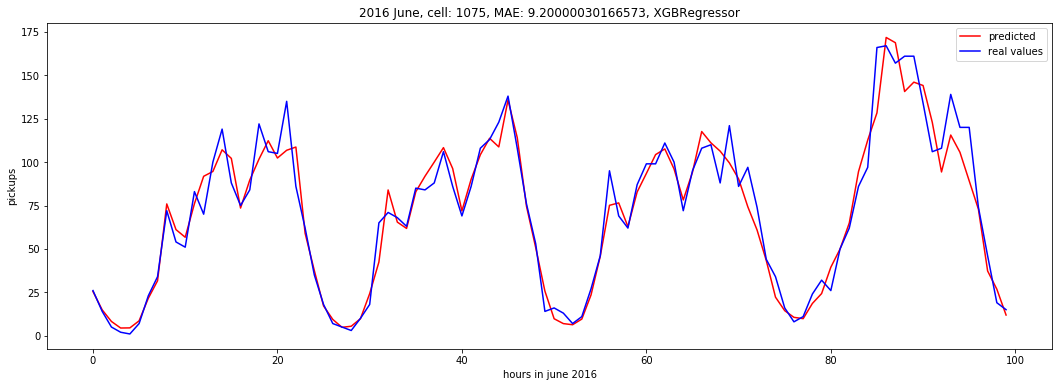

Сравнение всего июня


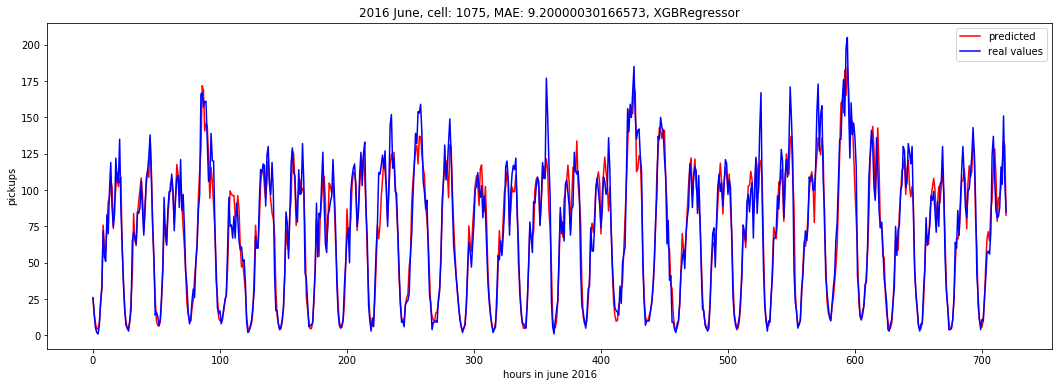

In [355]:
pred_arr, real_arr = prepare_data()
print ('Сравнение первых 100 часов')
plot_real_pred(pred_arr[:100], real_arr[:100])
print ('Сравнение всего июня')
plot_real_pred(pred_arr, real_arr)